## PUC Minas

#### Pós-Graduação em Ciência de Dados e Big Data (2018-2020)

#### Trabalho de Conclusão de Curso

##### Aluno: Leandro da Silva Câmara

##### Título: Previsão de Vendas com Prophet

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('seaborn')
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

Importing plotly failed. Interactive plots will not work.


#### Load Datasets

In [2]:
# Carregamento dos datasets.
items = pd.read_csv('datasets/items.csv')
sales = pd.read_csv('datasets/sales.csv')
items_categories = pd.read_csv('datasets/item_categories.csv')

In [3]:
# Dataset 'sales'.
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Data Processing

In [4]:
# Registros com valores negativos nas colunas 'item_price' e 'item_cnt_day'.
sales[sales['item_price'] < 0]
sales[sales['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [5]:
# Invertendo o 'sinal' dos valores negativos.
sales.loc[sales['item_price'] < 0, 'item_price'] *= -1
sales.loc[sales['item_cnt_day'] < 0, 'item_cnt_day'] *= -1

In [6]:
# Dataset corrigido/atualizado.
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
# Convertendo a coluna 'date' para o formato 'datetime'.
sales['date'] = sales['date'].apply(lambda d: pd.datetime.strptime(d, '%d.%m.%Y'))

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [8]:
# Criação das colunas 'year' (ano), 'month' (mês) e 'total_value' (valor total).
sales['year'] = sales['date'].apply(lambda d: d.year)
sales['month'] = sales['date'].apply(lambda d: d.month)
sales['total_value'] = sales['item_price'] * sales['item_cnt_day']

In [9]:
# Adicionando a coluna 'item_category_id' ao dataset 'sales'.
sales = sales.set_index('item_id')\
    .join(items.set_index('item_id'))\
    .drop('item_name', axis=1).reset_index()

In [10]:
# Dataset 'sales' após o processamento/tratamento dos dados.
sales.head()

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,year,month,total_value,item_category_id
0,0,2014-09-01,20,54,58.0,1.0,2014,9,58.0,40
1,1,2014-04-04,15,55,4490.0,1.0,2014,4,4490.0,76
2,1,2014-04-02,15,55,4490.0,1.0,2014,4,4490.0,76
3,1,2014-07-06,18,55,4490.0,1.0,2014,7,4490.0,76
4,1,2014-08-04,19,55,4490.0,1.0,2014,8,4490.0,76


### Data Analysis and Exploration

In [11]:
# Retorna o total de receita e de vendas de acordo com o ano e o agrupamento informado.
def sales_revenue_by_year(year, group_column):
    return sales[sales['year']==year]\
        .groupby([group_column])['item_cnt_day', 'total_value'].sum()

# Obtendo o total mensal de receita e de vendas dos anos de 2013, 2014 e 2015.
monthly_2013 = sales_revenue_by_year(year=2013, group_column='month')
monthly_2014 = sales_revenue_by_year(year=2014, group_column='month')
monthly_2015 = sales_revenue_by_year(year=2015, group_column='month')

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [12]:
# Retorna a diferença (%) média entre os anos, dos 10 primeiros meses.
def diff_mean_percent_years(column):
    diff = pd.DataFrame({
        2013: monthly_2013[column][:10],
        2014: monthly_2014[column][:10],
        2015: monthly_2015[column]
    }).pct_change(axis=1).mean() * 100

    print("2013-2014: {:.2f}%".format(diff[2014]))
    print("2014-2015: {:.2f}%".format(diff[2015]))

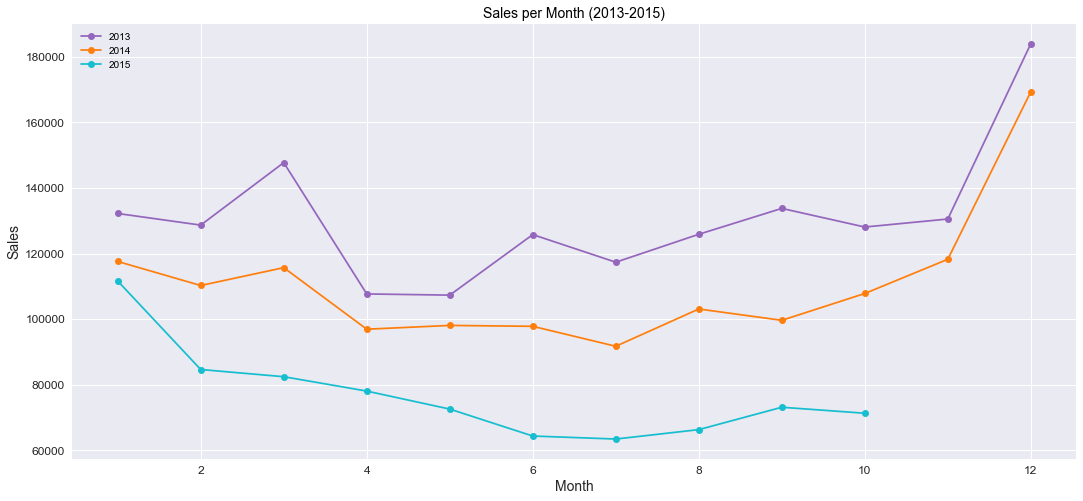

In [13]:
# Gráfico - Vendas por Mês (2013-2015)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_xlabel('Month')
axs.set_ylabel('Sales')
axs.set_title('Sales per Month (2013-2015)')
axs.plot(monthly_2013['item_cnt_day'], '-ok', c='tab:purple', label='2013')
axs.plot(monthly_2014['item_cnt_day'], '-ok', c='tab:orange', label='2014')
axs.plot(monthly_2015['item_cnt_day'], '-ok', c='tab:cyan', label='2015')
plt.legend()

In [14]:
# Retorna a diferença média das vendas entre os anos, em porcentagens.
diff_mean_percent_years('item_cnt_day')

2013-2014: -16.92%
2014-2015: -26.37%


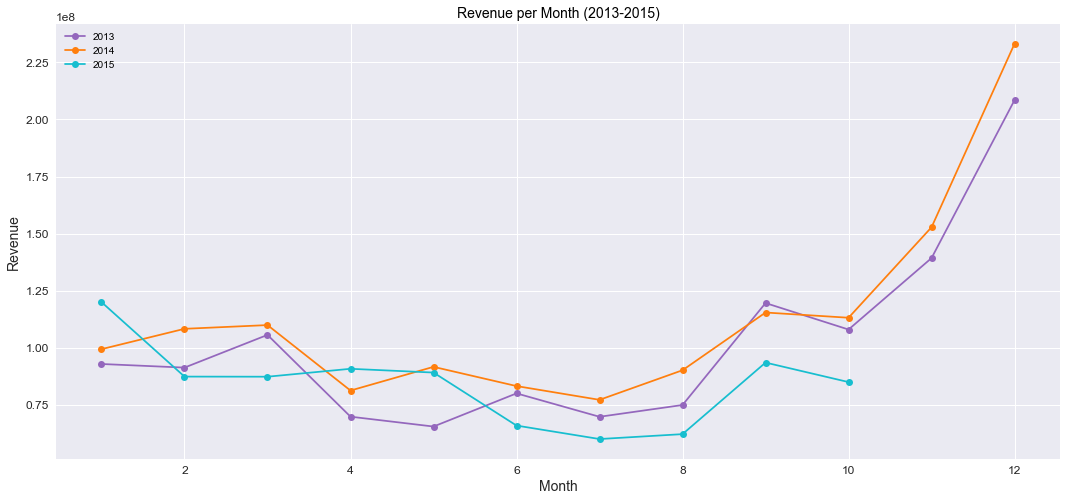

In [15]:
# Gráfico - Receita por Mês (2013-2015)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_xlabel('Month')
axs.set_ylabel('Revenue')
axs.set_title('Revenue per Month (2013-2015)')
axs.plot(monthly_2013['total_value'], '-ok', c='tab:purple', label='2013')
axs.plot(monthly_2014['total_value'], '-ok', c='tab:orange', label='2014')
axs.plot(monthly_2015['total_value'], '-ok', c='tab:cyan', label='2015')
plt.legend()

In [16]:
# Retorna a diferença média da receita entre os anos, em porcentagens.
diff_mean_percent_years('total_value')

2013-2014: 12.24%
2014-2015: -12.82%


In [17]:
# Retorna uma linha de melhor ajuste, para plotagem de uma regressão linear.
def sales_revenue_line_reg(dataset):
    # m = Inclinação; b = Interceptação
    m, b = np.polyfit(dataset['item_cnt_day'], dataset['total_value'], 1)
    return (m * dataset['item_cnt_day']) + b

In [18]:
# Obtendo o total de receita e de vendas de cada loja, nos anos de 2013, 2014 e 2015.
shops_2013 = sales_revenue_by_year(year=2013, group_column='shop_id')
shops_2014 = sales_revenue_by_year(year=2014, group_column='shop_id')
shops_2015 = sales_revenue_by_year(year=2015, group_column='shop_id')

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


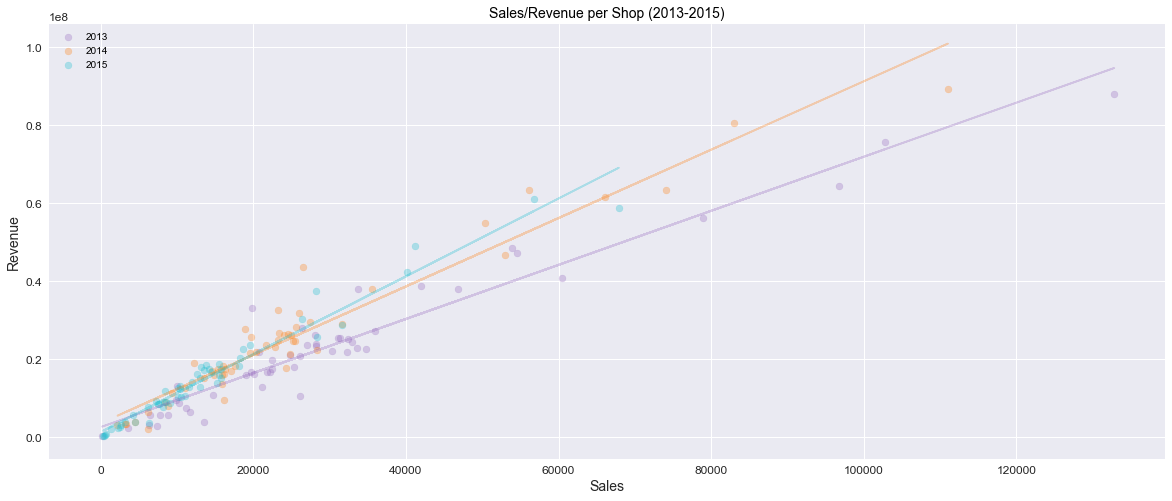

In [19]:
# Gráfico - Vendas/Receita por Loja (2013-2015)
fig, axs = plt.subplots(figsize=(20, 8))
axs.set_xlabel('Sales')
axs.set_ylabel('Revenue')
axs.set_title('Sales/Revenue per Shop (2013-2015)')
axs.scatter(shops_2013['item_cnt_day'], shops_2013['total_value'], c='tab:purple', alpha=.3, label='2013')
axs.scatter(shops_2014['item_cnt_day'], shops_2014['total_value'], c='tab:orange', alpha=.3, label='2014')
axs.scatter(shops_2015['item_cnt_day'], shops_2015['total_value'], c='tab:cyan', alpha=.3, label='2015')
# Adicionando ao gráfico, uma linha de melhor ajuste (Regressão Linear) para cada ano.
axs.plot(shops_2013['item_cnt_day'], sales_revenue_line_reg(shops_2013), c='tab:purple', alpha=.3)
axs.plot(shops_2014['item_cnt_day'], sales_revenue_line_reg(shops_2014), c='tab:orange', alpha=.3)
axs.plot(shops_2015['item_cnt_day'], sales_revenue_line_reg(shops_2015), c='tab:cyan', alpha=.3)
plt.legend()

In [20]:
# Obtendo o total de receita e de vendas relacionada a cada categoria de produtos.
categ_2013 = sales_revenue_by_year(year=2013, group_column='item_category_id')
categ_2014 = sales_revenue_by_year(year=2014, group_column='item_category_id')
categ_2015 = sales_revenue_by_year(year=2015, group_column='item_category_id')

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


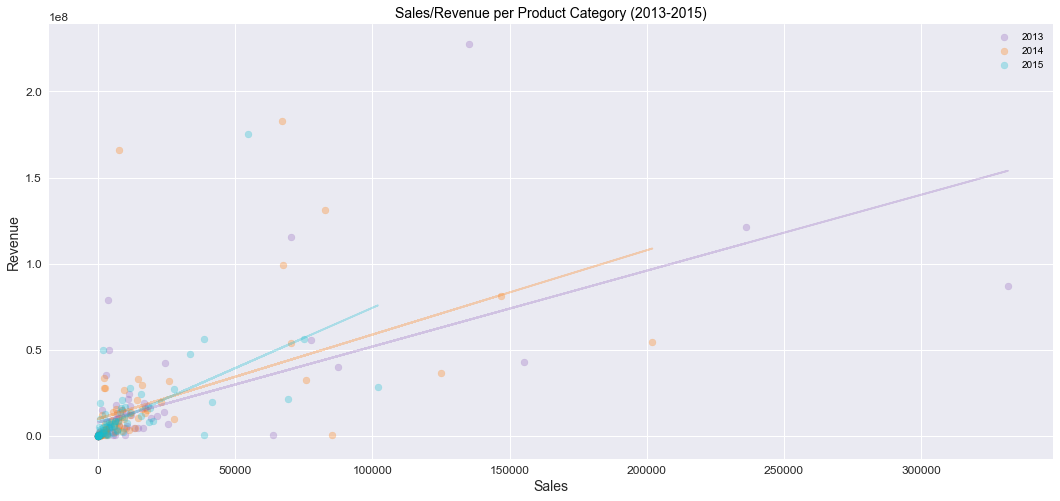

In [21]:
# Gráfico - Vendas/Receita por Categoria de Produto (2013-2015)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_xlabel('Sales')
axs.set_ylabel('Revenue')
axs.set_title('Sales/Revenue per Product Category (2013-2015)')
axs.scatter(categ_2013['item_cnt_day'], categ_2013['total_value'], c='tab:purple', alpha=.3, label='2013')
axs.scatter(categ_2014['item_cnt_day'], categ_2014['total_value'], c='tab:orange', alpha=.3, label='2014')
axs.scatter(categ_2015['item_cnt_day'], categ_2015['total_value'], c='tab:cyan', alpha=.3, label='2015')
# Adicionando ao gráfico, uma linha de melhor ajuste (Regressão Linear) para cada ano.
axs.plot(categ_2013['item_cnt_day'], sales_revenue_line_reg(categ_2013), c='tab:purple', alpha=.3)
axs.plot(categ_2014['item_cnt_day'], sales_revenue_line_reg(categ_2014), c='tab:orange', alpha=.3)
axs.plot(categ_2015['item_cnt_day'], sales_revenue_line_reg(categ_2015), c='tab:cyan', alpha=.3)
plt.legend()

In [22]:
# Obtendo o total mensal de receita e de vendas - Janeiro/2013 a Outubro/2015 (34 meses)
total_sales = sales.groupby(['date_block_num'])['item_cnt_day', 'total_value'].sum()

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


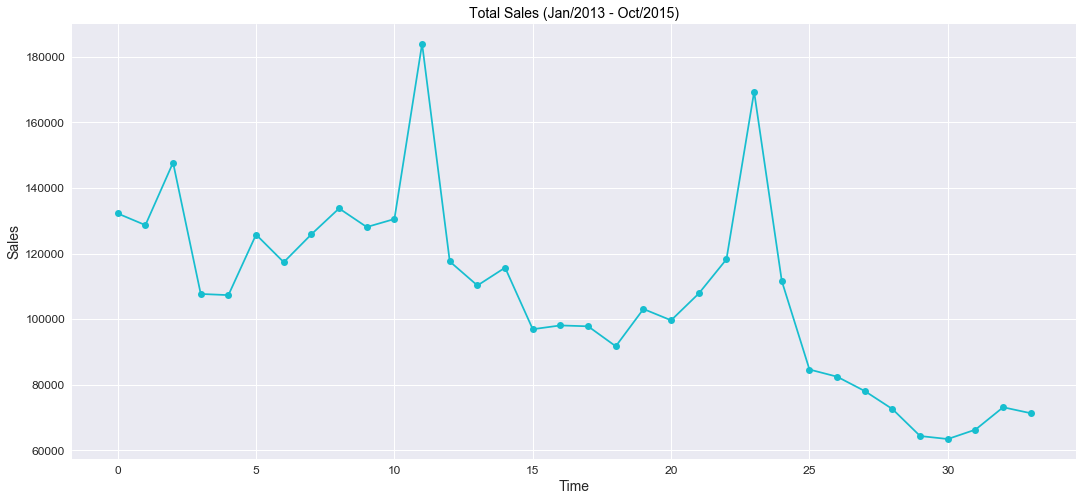

In [23]:
# Gráfico - Total de Vendas (Jan/2013 - Out/2015)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_xlabel('Time')
axs.set_ylabel('Sales')
axs.set_title('Total Sales (Jan/2013 - Oct/2015)')
axs.plot(total_sales['item_cnt_day'], '-ok', c='tab:cyan')

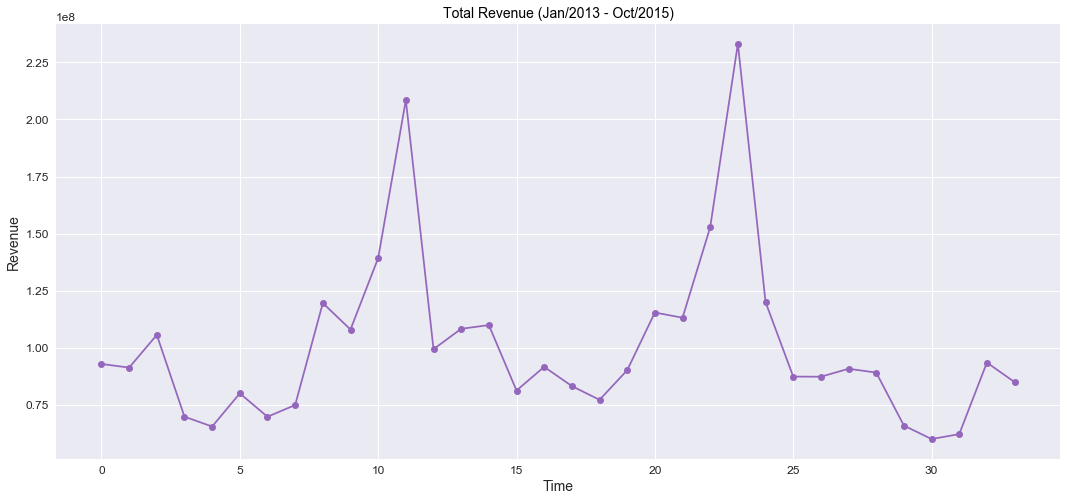

In [24]:
# Gráfico - Total de Receita (Jan/2013 - Out/2015)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_xlabel('Time')
axs.set_ylabel('Revenue')
axs.set_title('Total Revenue (Jan/2013 - Oct/2015)')
axs.plot(total_sales['total_value'], '-ok', c='tab:purple')

In [25]:
# Obtendo as tendências e as sazonalidades das vendas e da receita
decompose_sales = seasonal_decompose(total_sales['item_cnt_day'].values, freq=12)
decompose_revenue = seasonal_decompose(total_sales['total_value'].values, freq=12)

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


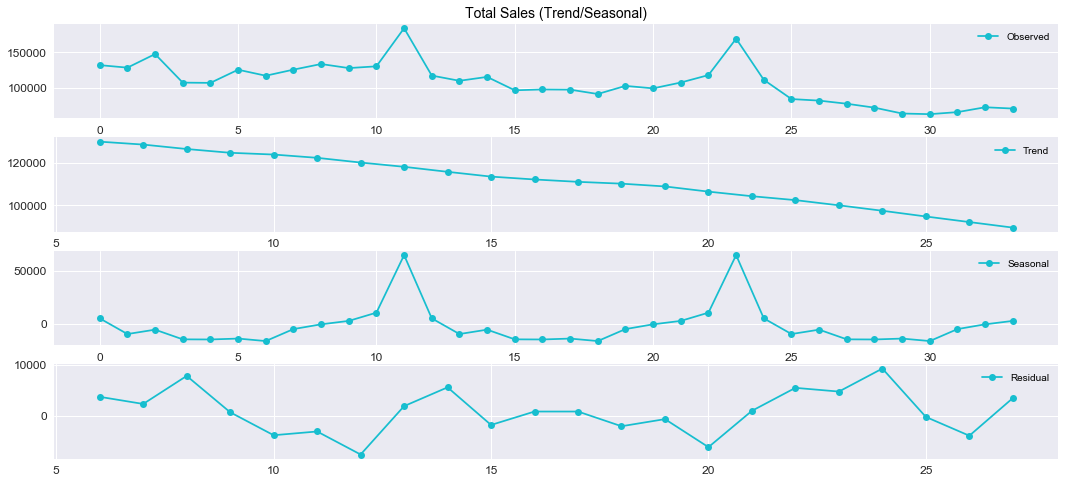

In [26]:
# Gráfico - Total de Vendas (Tendência/Sazonalidade)
fig, axs = plt.subplots(4, 1, figsize=(18, 8))
axs[0].set_title('Total Sales (Trend/Seasonal)')
axs[0].plot(total_sales['item_cnt_day'], '-ok', c='tab:cyan', label='Observed')
axs[1].plot(decompose_sales.trend, '-ok', c='tab:cyan', label='Trend')
axs[2].plot(decompose_sales.seasonal, '-ok', c='tab:cyan', label='Seasonal')
axs[3].plot(decompose_sales.resid, '-ok', c='tab:cyan', label='Residual')
for ax in axs.flat: ax.legend(loc='best')

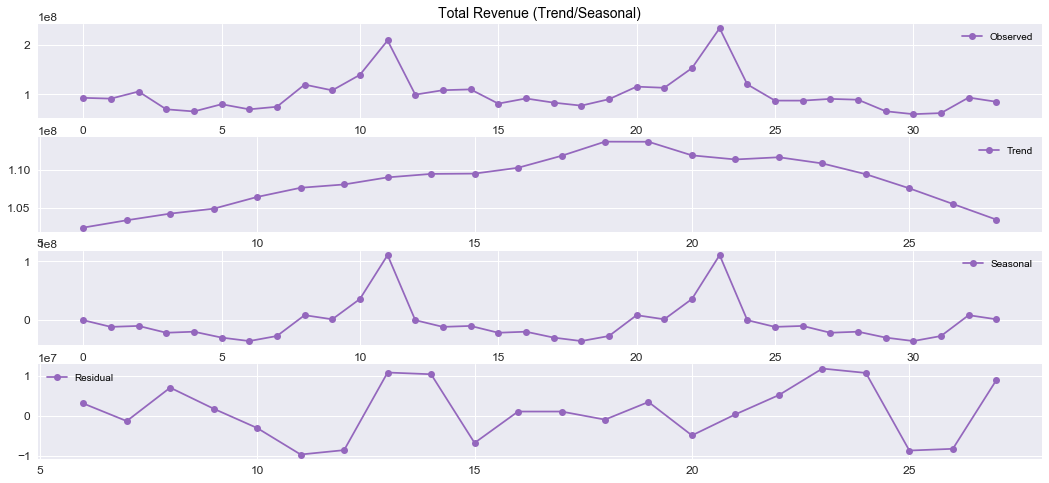

In [27]:
# Gráfico - Total de Receita (Tendência/Sazonalidade)
fig, axs = plt.subplots(4, 1, figsize=(18, 8))
axs[0].set_title('Total Revenue (Trend/Seasonal)')
axs[0].plot(total_sales['total_value'], '-ok', c='tab:purple', label='Observed')
axs[1].plot(decompose_revenue.trend, '-ok', c='tab:purple', label='Trend')
axs[2].plot(decompose_revenue.seasonal, '-ok', c='tab:purple', label='Seasonal')
axs[3].plot(decompose_revenue.resid, '-ok', c='tab:purple', label='Residual')
for ax in axs.flat: ax.legend(loc='best')

### Machine Learning Model

#### Preprocessing

In [28]:
# Obtendo as datas de início e fim da série temporal.
start_date = pd.datetime.strftime(sales['date'].min(), '%Y-%m-%d')
end_date = pd.datetime.strftime(sales['date'].max(), '%Y-%m-%d')

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# Agrupamento mensal com as somatórias de 'item_cnt_day' e 'total_value'.
total = sales.groupby(['date_block_num'])['item_cnt_day', 'total_value'].sum()
total.index = pd.date_range(start=start_date, end=end_date, freq='MS')
total = total.reset_index()

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [30]:
total.head()

,index,item_cnt_day,total_value
0,2013-01-01,132221.0,9.285109e+07
1,2013-02-01,128674.0,9.126327e+07
2,2013-03-01,147734.0,1.055981e+08
3,2013-04-01,107688.0,6.975997e+07
4,2013-05-01,107326.0,6.544102e+07


In [31]:
# Agrupamento mensal com o total de vendas. Removendo a coluna 'total_value'.
total_sales = total.drop('total_value', axis=1)
# Agrupamento mensal com a geração de receita. Removendo a coluna 'item_cnt_day'.
total_revenue = total.drop('item_cnt_day', axis=1)

#### Prophet Model

In [32]:
# Prophet exige que o 'dataset' seja um DataFrame (Pandas), com duas colunas:
# DS = coluna da data
# Y = coluna numérica e representa a medida que se deseja prever
total_sales.columns = ['ds', 'y']
total_revenue.columns = ['ds', 'y']

In [33]:
total_sales.head()

,ds,y
0,2013-01-01,132221.0
1,2013-02-01,128674.0
2,2013-03-01,147734.0
3,2013-04-01,107688.0
4,2013-05-01,107326.0


In [34]:
total_revenue.head()

,ds,y
0,2013-01-01,9.285109e+07
1,2013-02-01,9.126327e+07
2,2013-03-01,1.055981e+08
3,2013-04-01,6.975997e+07
4,2013-05-01,6.544102e+07


In [35]:
# Instanciando os modelos (Prophet), com sazonalidade anual, já que os dados são mensais.
# Definindo o intervalo de confiança (da tendência) de 95%.
model_sales = Prophet(yearly_seasonality=True, interval_width=0.95)
model_revenue = Prophet(yearly_seasonality=True, interval_width=0.95)

In [36]:
# Realizando o treinamento dos modelos referente à vendas e receita.
model_sales.fit(total_sales)
model_revenue.fit(total_revenue)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Forecasts

In [37]:
# Construindo o 'DataFrame' com o histórico e os próximos 5 meses.
# MS = Frequência 'Mensal'
future_sales = model_sales.make_future_dataframe(periods=5, freq='MS')
future_revenue = model_revenue.make_future_dataframe(periods=5, freq='MS')

In [38]:
future_sales.tail()
future_revenue.tail()

,ds
34,2015-11-01
35,2015-12-01
36,2016-01-01
37,2016-02-01
38,2016-03-01


In [39]:
# Realizando a previsão dos 5 meses incluídos no histórico, para vendas e receita.
forecasts_sales = model_sales.predict(future_sales)
forecasts_revenue = model_revenue.predict(future_revenue)

In [40]:
# YHAT = Valor previsto para as vendas dos próximos 5 meses.
forecasts_sales[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83471.686978,78932.371056,88349.689881
35,2015-12-01,125888.813985,121025.592995,130818.523853
36,2016-01-01,76082.514383,71280.135212,80819.200380
37,2016-02-01,40321.482693,35985.840215,44974.565227
38,2016-03-01,76778.364315,72080.010146,81694.394635


In [41]:
# YHAT = Valor previsto para a receita dos próximos 5 meses.
forecasts_revenue[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,1.248390e+08,1.184081e+08,1.316421e+08
35,2015-12-01,2.117112e+08,2.045977e+08,2.185492e+08
36,2016-01-01,8.874296e+07,8.200203e+07,9.516077e+07
37,2016-02-01,5.104640e+07,4.419532e+07,5.738600e+07
38,2016-03-01,9.863634e+07,9.161530e+07,1.059423e+08


#### Visualization

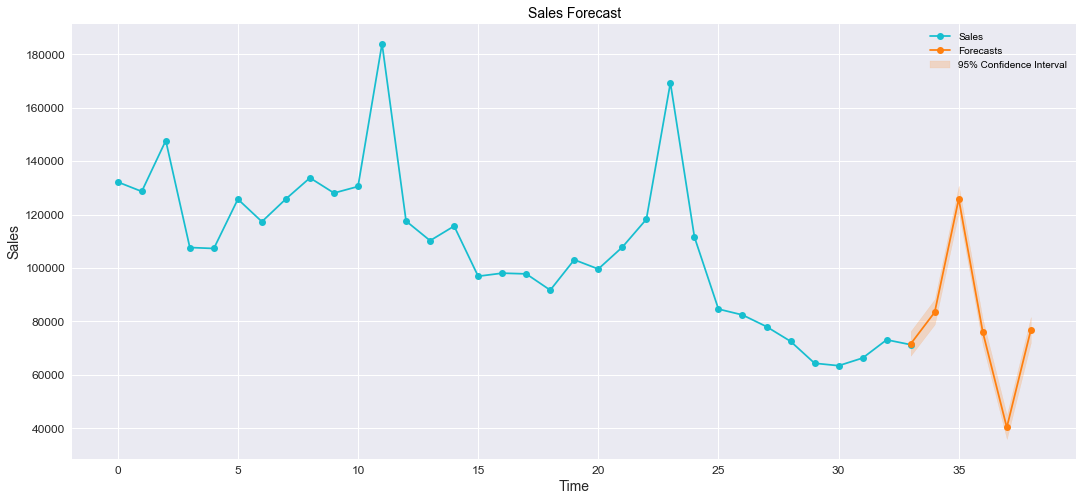

In [61]:
# Gráfico - Previsão de Vendas
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_title('Sales Forecast')
axs.set_ylabel('Sales')
axs.set_xlabel('Time')
axs.plot(total_sales.drop('ds', axis=1), '-ok', c='tab:cyan', label='Sales')
axs.plot(forecasts_sales[-6:].yhat, '-ok', c='tab:orange', label='Forecasts')
axs.fill_between(forecasts_sales[-6:].index, forecasts_sales[-6:].yhat_upper, forecasts_sales[-6:].yhat_lower,
                 alpha=.2, color='tab:orange', label='95% Confidence Interval')
plt.legend()

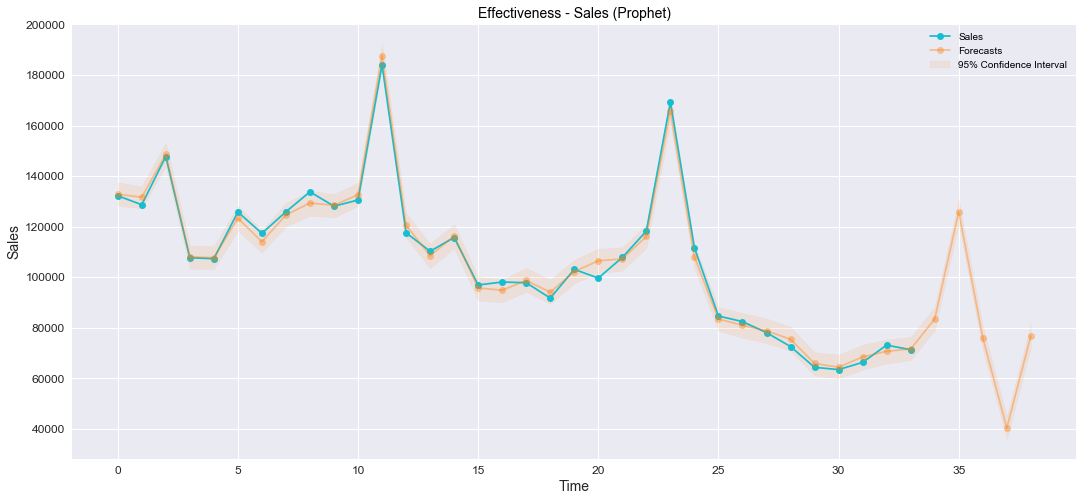

In [62]:
# Gráfico - Eficácia - Vendas (Prophet)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_title('Effectiveness - Sales (Prophet)')
axs.set_ylabel('Sales')
axs.set_xlabel('Time')
axs.plot(total_sales.drop('ds', axis=1), '-ok', c='tab:cyan', label='Sales')
axs.plot(forecasts_sales.yhat, '-ok', c='tab:orange', alpha=.4, label='Forecasts')
axs.fill_between(forecasts_sales.index, forecasts_sales.yhat_upper, forecasts_sales.yhat_lower,
                 alpha=.1, color='tab:orange', label='95% Confidence Interval')
plt.legend()

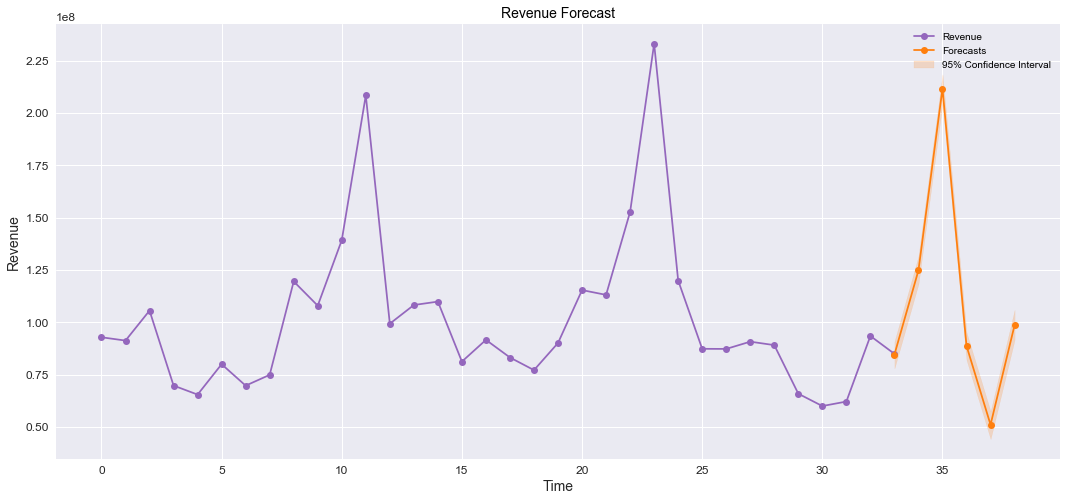

In [63]:
# Gráfico - Previsão de Receita
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_title('Revenue Forecast')
axs.set_ylabel('Revenue')
axs.set_xlabel('Time')
axs.plot(total_revenue.drop('ds', axis=1), '-ok', c='tab:purple', label='Revenue')
axs.plot(forecasts_revenue[-6:].yhat, '-ok', c='tab:orange', label='Forecasts')
axs.fill_between(forecasts_revenue[-6:].index, forecasts_revenue[-6:].yhat_upper,forecasts_revenue[-6:].yhat_lower,
                 alpha=.2, color='tab:orange', label='95% Confidence Interval')
plt.legend()

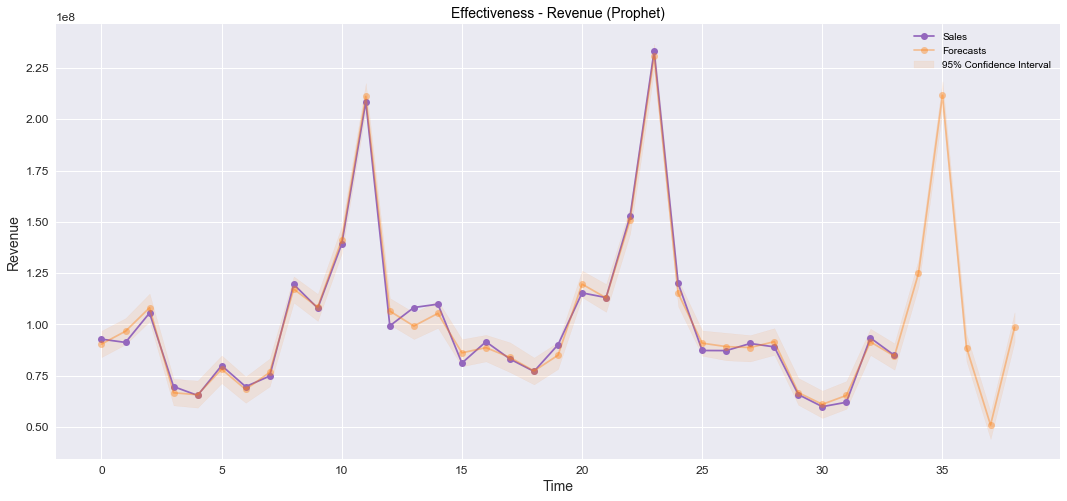

In [64]:
# Gráfico - Eficácia - Receita (Prophet)
fig, axs = plt.subplots(figsize=(18, 8))
axs.set_title('Effectiveness - Revenue (Prophet)')
axs.set_ylabel('Revenue')
axs.set_xlabel('Time')
axs.plot(total_revenue.drop('ds', axis=1), '-ok', c='tab:purple', label='Sales')
axs.plot(forecasts_revenue.yhat, '-ok', c='tab:orange', alpha=.4, label='Forecasts')
axs.fill_between(forecasts_revenue.index, forecasts_revenue.yhat_upper, forecasts_revenue.yhat_lower,
                 alpha=.1, color='tab:orange', label='95% Confidence Interval')
plt.legend()

In [67]:
# Trend, yearly seasonality, and weekly seasonality of the time series.
decompose_forecasts_sales = seasonal_decompose(forecasts_sales.yhat, freq=12)
decompose_forecasts_revenue = seasonal_decompose(forecasts_revenue.yhat, freq=12)

C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\leand\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


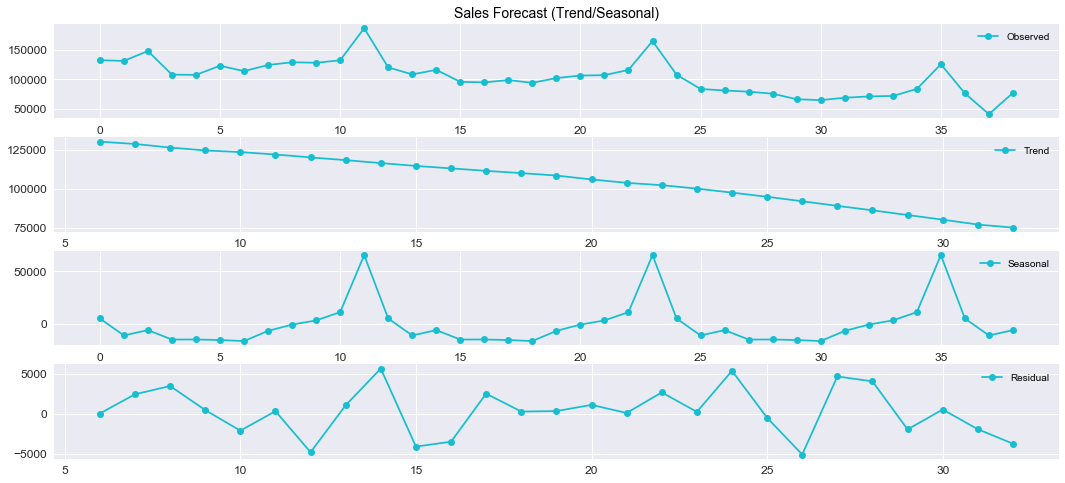

In [72]:
# Gráfico - Previsão de Vendas (Tendência/Sazonalidade)
fig, axs = plt.subplots(4, 1, figsize=(18, 8))
axs[0].set_title('Sales Forecast (Trend/Seasonal)')
axs[0].plot(forecasts_sales.yhat, '-ok', c='tab:cyan', label='Observed')
axs[1].plot(decompose_forecasts_sales.trend, '-ok', c='tab:cyan', label='Trend')
axs[2].plot(decompose_forecasts_sales.seasonal, '-ok', c='tab:cyan', label='Seasonal')
axs[3].plot(decompose_forecasts_sales.resid, '-ok', c='tab:cyan', label='Residual')
for ax in axs.flat: ax.legend(loc='best')

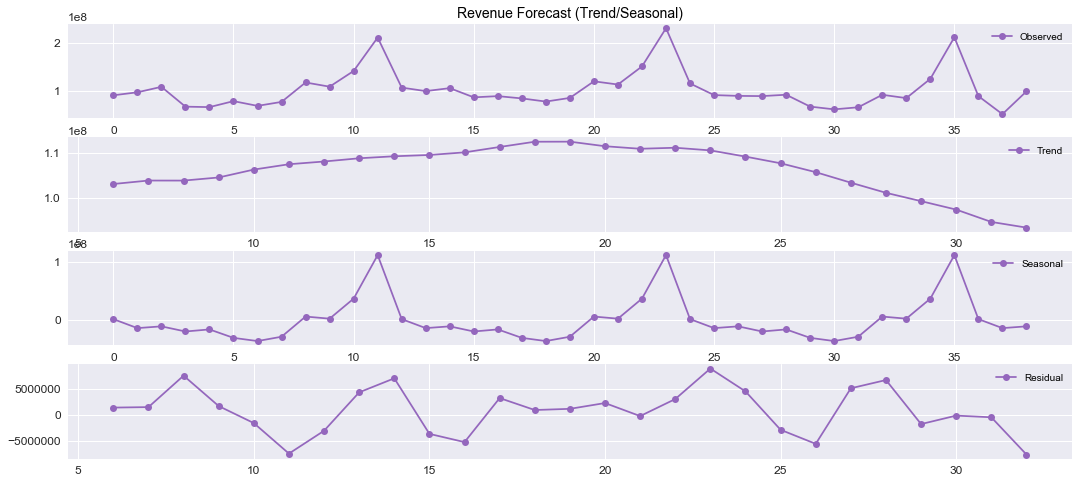

In [73]:
# Gráfico - Previsão de Receita (Tendência/Sazonalidade)
fig, axs = plt.subplots(4, 1, figsize=(18, 8))
axs[0].set_title('Revenue Forecast (Trend/Seasonal)')
axs[0].plot(forecasts_revenue.yhat, '-ok', c='tab:purple', label='Observed')
axs[1].plot(decompose_forecasts_revenue.trend, '-ok', c='tab:purple', label='Trend')
axs[2].plot(decompose_forecasts_revenue.seasonal, '-ok', c='tab:purple', label='Seasonal')
axs[3].plot(decompose_forecasts_revenue.resid, '-ok', c='tab:purple', label='Residual')
for ax in axs.flat: ax.legend(loc='best')
